# Load in the dataset:

In [ ]:
from google.colab import drive

# Mount Google Drive to access files and folders
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Thesis code/healthy_scab_FDs/'
train_path = '/content/drive/MyDrive/Thesis code/healthy_scab_FDs/training/'
val_path = '/content/drive/MyDrive/Thesis code/healthy_scab_FDs/validation/'
train_val_path = '/content/drive/MyDrive/Thesis code/healthy_scab_FDs/train_val'
test_path = '/content/drive/MyDrive/Thesis code/healthy_scab_FDs/test/'

# Download/import libraries

In [ ]:
!pip install timm
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.3/224.3 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00


In [ ]:
import os
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import timm
from optuna.trial import TrialState
from torchvision import datasets
from torchvision import transforms

# Calculate class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_dataset = ImageFolder(train_path)

targets = train_dataset.targets
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)

print(class_weights)

[1.64814815 0.71774194]


In [ ]:
# class weights train_val dataset
train_val_dataset = ImageFolder(train_val_path)

targets = train_val_dataset.targets
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)

print(class_weights)

[1.64583333 0.71818182]


# Model Maxvit

In [ ]:
timm.list_models('*maxvit*', pretrained=True) # 'maxvit_rmlp_small_rw_224'

['maxvit_base_tf_224.in1k',
 'maxvit_base_tf_224.in21k',
 'maxvit_base_tf_384.in1k',
 'maxvit_base_tf_384.in21k_ft_in1k',
 'maxvit_base_tf_512.in1k',
 'maxvit_base_tf_512.in21k_ft_in1k',
 'maxvit_large_tf_224.in1k',
 'maxvit_large_tf_224.in21k',
 'maxvit_large_tf_384.in1k',
 'maxvit_large_tf_384.in21k_ft_in1k',
 'maxvit_large_tf_512.in1k',
 'maxvit_large_tf_512.in21k_ft_in1k',
 'maxvit_nano_rw_256.sw_in1k',
 'maxvit_rmlp_base_rw_224.sw_in12k',
 'maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k',
 'maxvit_rmlp_base_rw_384.sw_in12k_ft_in1k',
 'maxvit_rmlp_nano_rw_256.sw_in1k',
 'maxvit_rmlp_pico_rw_256.sw_in1k',
 'maxvit_rmlp_small_rw_224.sw_in1k',
 'maxvit_rmlp_tiny_rw_256.sw_in1k',
 'maxvit_small_tf_224.in1k',
 'maxvit_small_tf_384.in1k',
 'maxvit_small_tf_512.in1k',
 'maxvit_tiny_rw_224.sw_in1k',
 'maxvit_tiny_tf_224.in1k',
 'maxvit_tiny_tf_384.in1k',
 'maxvit_tiny_tf_512.in1k',
 'maxvit_xlarge_tf_224.in21k',
 'maxvit_xlarge_tf_384.in21k_ft_in1k',
 'maxvit_xlarge_tf_512.in21k_ft_in1k']

In [ ]:
from sklearn import metrics
from sklearn.metrics import f1_score


# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define parameters
BATCHSIZE = 16
epochs = 100

# Calculate class weights
train_dataset = ImageFolder(train_path)
targets = train_dataset.targets
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)

class_weights_tensor = torch.from_numpy(class_weights)
class_weights_tensor = class_weights_tensor.to(torch.float32)

class_weights_tensor = class_weights_tensor.to(DEVICE)



def define_model(trial):
  model = timm.create_model('maxvit_tiny_rw_224', pretrained=True, in_chans=3) 
  
  for param in model.parameters():
    param.requires_grad = False
    
  num_in_features = model.get_classifier().in_features
    
  head = []
  head.append(nn.BatchNorm1d(num_in_features))
  hidden_layers = trial.suggest_int('hidden_layers', 1, 2)
  for i in range(hidden_layers):
    first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512])
    head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
    head.append(nn.ReLU())
    drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
    head.append(nn.Dropout(p=drop_out))
    num_in_features = first_neuron
    
  head.append(nn.Linear(in_features=num_in_features, out_features=2))
  
  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():      
    param.requires_grad = True

  return model

def get_dataset():
  import torchvision.transforms as transforms
  from torchvision.datasets import ImageFolder

  transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
  
  transform_valid = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  
  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)
  
  train_data = next(iter(train_loader))
  valid_data = next(iter(valid_loader))

  return train_loader, valid_loader

def objective(trial):
  
    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Generate a loss function

    # Define your loss function with class_weights_tensor
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_dataset()

    # Initialize variables for early stopping
    best_loss = 1000000
    patience = 5
    no_improvement_count = 0

    # Train the model with early stopping
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        best_f1_score = 0.0
        total_train = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()    # Backpropagate the gradients
            optimizer.step()   # Update the model parameters

            running_loss += loss.item()

            # Compute the train accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Compute the train loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct_train / total_train

        # Evaluate the model on the validation set
        model.eval()
        correct_valid = 0
        total_valid = 0
        y_true, y_pred = [], []
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)

                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

                y_true += labels.cpu().tolist()
                y_pred += predicted.cpu().tolist()

        # Compute the validation loss and accuracy
        valid_loss /= len(valid_loader)
        valid_accuracy = 100.0 * correct_valid / total_valid


        #calculate the macro f1-score
        f1_score = metrics.f1_score(y_true, y_pred, average='macro')

        # Print the results for this epoch
        print(f"Epoch {epoch}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%, F1_score: {f1_score:.4f}")

        # Report the intermediate result
        trial.report(f1_score, epoch)

        # Check if the validation loss has improved, and if not, increase the no_improvement_count
        if valid_loss < best_loss:
            best_loss = valid_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if the f1 score has improved
        if f1_score > best_f1_score:
            best_f1_score = f1_score

        # Check if early stopping criterion is met
        if no_improvement_count >= patience:
            print("Early stopping criterion met at epoch {}".format(epoch))
            break

        # Handle pruning based on the intermediate result
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_f1_score


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-05-16 10:52:02,876] A new study created in memory with name: no-name-88c384b5-4074-4442-b83b-bab3a3d58d6b


Epoch 0/100 - Train Loss: 0.6245, Train Accuracy: 60.11% - Valid Loss: 0.6864, Valid Accuracy: 66.10%, F1_score: 0.6003
Epoch 1/100 - Train Loss: 0.5222, Train Accuracy: 79.21% - Valid Loss: 0.6136, Valid Accuracy: 64.41%, F1_score: 0.6075
Epoch 2/100 - Train Loss: 0.4285, Train Accuracy: 83.15% - Valid Loss: 0.6537, Valid Accuracy: 74.58%, F1_score: 0.6398
Epoch 3/100 - Train Loss: 0.3965, Train Accuracy: 79.21% - Valid Loss: 0.5580, Valid Accuracy: 72.88%, F1_score: 0.6695
Epoch 4/100 - Train Loss: 0.3739, Train Accuracy: 83.71% - Valid Loss: 0.5261, Valid Accuracy: 71.19%, F1_score: 0.6890
Epoch 5/100 - Train Loss: 0.5348, Train Accuracy: 79.78% - Valid Loss: 0.4275, Valid Accuracy: 83.05%, F1_score: 0.8109
Epoch 6/100 - Train Loss: 0.4066, Train Accuracy: 83.71% - Valid Loss: 0.4785, Valid Accuracy: 71.19%, F1_score: 0.6994
Epoch 7/100 - Train Loss: 0.4690, Train Accuracy: 76.40% - Valid Loss: 0.4565, Valid Accuracy: 83.05%, F1_score: 0.8001
Epoch 8/100 - Train Loss: 0.3052, Train 

[I 2023-05-16 11:02:51,634] Trial 0 finished with value: 0.7893541058098019 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.0015579314094241253}. Best is trial 0 with value: 0.7893541058098019.


Epoch 10/100 - Train Loss: 0.3821, Train Accuracy: 86.52% - Valid Loss: 0.4576, Valid Accuracy: 81.36%, F1_score: 0.7894
Early stopping criterion met at epoch 10
Epoch 0/100 - Train Loss: 150.6282, Train Accuracy: 56.74% - Valid Loss: 98.8036, Valid Accuracy: 74.58%, F1_score: 0.5655
Epoch 1/100 - Train Loss: 30.5333, Train Accuracy: 65.73% - Valid Loss: 17.0046, Valid Accuracy: 62.71%, F1_score: 0.4849
Epoch 2/100 - Train Loss: 7.9448, Train Accuracy: 74.72% - Valid Loss: 11.4397, Valid Accuracy: 72.88%, F1_score: 0.6054
Epoch 3/100 - Train Loss: 8.5034, Train Accuracy: 76.97% - Valid Loss: 4.7544, Valid Accuracy: 71.19%, F1_score: 0.6653
Epoch 4/100 - Train Loss: 5.1376, Train Accuracy: 71.35% - Valid Loss: 4.5646, Valid Accuracy: 72.88%, F1_score: 0.6054
Epoch 5/100 - Train Loss: 2.1788, Train Accuracy: 77.53% - Valid Loss: 4.8694, Valid Accuracy: 71.19%, F1_score: 0.5686
Epoch 6/100 - Train Loss: 2.7773, Train Accuracy: 78.09% - Valid Loss: 2.8676, Valid Accuracy: 67.80%, F1_score:

[I 2023-05-16 11:20:57,704] Trial 1 finished with value: 0.5530303030303031 and parameters: {'hidden_layers': 1, 'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.03241155409537591}. Best is trial 0 with value: 0.7893541058098019.


Epoch 17/100 - Train Loss: 0.7324, Train Accuracy: 75.28% - Valid Loss: 0.9289, Valid Accuracy: 72.88%, F1_score: 0.5530
Early stopping criterion met at epoch 17
Epoch 0/100 - Train Loss: 0.6854, Train Accuracy: 65.73% - Valid Loss: 0.6821, Valid Accuracy: 66.10%, F1_score: 0.3980
Epoch 1/100 - Train Loss: 0.6769, Train Accuracy: 70.22% - Valid Loss: 0.6887, Valid Accuracy: 66.10%, F1_score: 0.3980
Epoch 2/100 - Train Loss: 0.6466, Train Accuracy: 76.97% - Valid Loss: 0.6843, Valid Accuracy: 67.80%, F1_score: 0.4870
Epoch 3/100 - Train Loss: 0.6366, Train Accuracy: 79.21% - Valid Loss: 0.6818, Valid Accuracy: 67.80%, F1_score: 0.5178
Epoch 4/100 - Train Loss: 0.6485, Train Accuracy: 79.78% - Valid Loss: 0.6742, Valid Accuracy: 69.49%, F1_score: 0.5293
Epoch 5/100 - Train Loss: 0.6110, Train Accuracy: 77.53% - Valid Loss: 0.6700, Valid Accuracy: 69.49%, F1_score: 0.5560
Epoch 6/100 - Train Loss: 0.6064, Train Accuracy: 83.71% - Valid Loss: 0.6790, Valid Accuracy: 69.49%, F1_score: 0.556

[I 2023-05-16 12:07:08,479] Trial 2 finished with value: 0.7934173669467788 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 8.404541287769256e-05}. Best is trial 2 with value: 0.7934173669467788.


Epoch 45/100 - Train Loss: 0.2858, Train Accuracy: 87.64% - Valid Loss: 0.4102, Valid Accuracy: 83.05%, F1_score: 0.7934
Early stopping criterion met at epoch 45
Epoch 0/100 - Train Loss: 0.6802, Train Accuracy: 58.43% - Valid Loss: 0.6618, Valid Accuracy: 74.58%, F1_score: 0.6194
Epoch 1/100 - Train Loss: 0.5632, Train Accuracy: 73.03% - Valid Loss: 0.6370, Valid Accuracy: 71.19%, F1_score: 0.5410
Epoch 2/100 - Train Loss: 0.5201, Train Accuracy: 81.46% - Valid Loss: 0.6354, Valid Accuracy: 69.49%, F1_score: 0.6141
Epoch 3/100 - Train Loss: 0.5193, Train Accuracy: 75.84% - Valid Loss: 0.7008, Valid Accuracy: 72.88%, F1_score: 0.5530
Epoch 4/100 - Train Loss: 0.4659, Train Accuracy: 79.21% - Valid Loss: 0.6380, Valid Accuracy: 77.97%, F1_score: 0.6490
Epoch 5/100 - Train Loss: 0.3576, Train Accuracy: 82.58% - Valid Loss: 0.5902, Valid Accuracy: 79.66%, F1_score: 0.7040
Epoch 6/100 - Train Loss: 0.3761, Train Accuracy: 84.27% - Valid Loss: 0.5748, Valid Accuracy: 84.75%, F1_score: 0.794

[I 2023-05-16 12:29:50,103] Trial 3 finished with value: 0.8865384615384615 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.000617413663868752}. Best is trial 3 with value: 0.8865384615384615.


Epoch 22/100 - Train Loss: 0.3190, Train Accuracy: 87.08% - Valid Loss: 0.3544, Valid Accuracy: 89.83%, F1_score: 0.8865
Early stopping criterion met at epoch 22
Epoch 0/100 - Train Loss: 0.6161, Train Accuracy: 65.17% - Valid Loss: 0.7581, Valid Accuracy: 62.71%, F1_score: 0.4849
Epoch 1/100 - Train Loss: 0.5100, Train Accuracy: 74.16% - Valid Loss: 0.8478, Valid Accuracy: 74.58%, F1_score: 0.5950
Epoch 2/100 - Train Loss: 0.5575, Train Accuracy: 71.91% - Valid Loss: 0.5198, Valid Accuracy: 79.66%, F1_score: 0.7782
Epoch 3/100 - Train Loss: 0.3430, Train Accuracy: 88.20% - Valid Loss: 0.6808, Valid Accuracy: 62.71%, F1_score: 0.6262
Epoch 4/100 - Train Loss: 0.5885, Train Accuracy: 78.09% - Valid Loss: 0.4516, Valid Accuracy: 76.27%, F1_score: 0.7463
Epoch 5/100 - Train Loss: 0.3767, Train Accuracy: 80.90% - Valid Loss: 0.5227, Valid Accuracy: 84.75%, F1_score: 0.7943
Epoch 6/100 - Train Loss: 0.3340, Train Accuracy: 82.02% - Valid Loss: 0.4883, Valid Accuracy: 83.05%, F1_score: 0.776

[I 2023-05-16 12:39:51,550] Trial 4 finished with value: 0.751054852320675 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 0.004658724458951785}. Best is trial 3 with value: 0.8865384615384615.


Epoch 9/100 - Train Loss: 0.3964, Train Accuracy: 85.39% - Valid Loss: 0.5346, Valid Accuracy: 77.97%, F1_score: 0.7511
Early stopping criterion met at epoch 9


[I 2023-05-16 12:41:01,727] Trial 5 pruned. 


Epoch 0/100 - Train Loss: 0.6128, Train Accuracy: 69.10% - Valid Loss: 0.6813, Valid Accuracy: 57.63%, F1_score: 0.5426
Epoch 0/100 - Train Loss: 4.6156, Train Accuracy: 60.11% - Valid Loss: 1.1793, Valid Accuracy: 67.80%, F1_score: 0.6588
Epoch 1/100 - Train Loss: 1.1961, Train Accuracy: 70.22% - Valid Loss: 3.9697, Valid Accuracy: 69.49%, F1_score: 0.4582
Epoch 2/100 - Train Loss: 1.0091, Train Accuracy: 73.60% - Valid Loss: 0.7955, Valid Accuracy: 71.19%, F1_score: 0.6653
Epoch 3/100 - Train Loss: 0.5864, Train Accuracy: 75.84% - Valid Loss: 0.7369, Valid Accuracy: 79.66%, F1_score: 0.7427
Epoch 4/100 - Train Loss: 0.6188, Train Accuracy: 74.16% - Valid Loss: 0.7150, Valid Accuracy: 55.93%, F1_score: 0.5582
Epoch 5/100 - Train Loss: 0.4456, Train Accuracy: 79.78% - Valid Loss: 1.0340, Valid Accuracy: 72.88%, F1_score: 0.6054
Epoch 6/100 - Train Loss: 0.5955, Train Accuracy: 79.21% - Valid Loss: 0.5816, Valid Accuracy: 74.58%, F1_score: 0.7256
Epoch 7/100 - Train Loss: 0.3849, Train 

[I 2023-05-16 12:56:00,950] Trial 6 finished with value: 0.7127555988315482 and parameters: {'hidden_layers': 1, 'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.0059989374684297535}. Best is trial 3 with value: 0.8865384615384615.


Epoch 14/100 - Train Loss: 0.3634, Train Accuracy: 88.20% - Valid Loss: 0.5998, Valid Accuracy: 74.58%, F1_score: 0.7128
Early stopping criterion met at epoch 14


[I 2023-05-16 12:57:07,307] Trial 7 pruned. 


Epoch 0/100 - Train Loss: 2.4463, Train Accuracy: 64.61% - Valid Loss: 2.7183, Valid Accuracy: 62.71%, F1_score: 0.5283


[I 2023-05-16 12:58:15,306] Trial 8 pruned. 


Epoch 0/100 - Train Loss: 90792.2873, Train Accuracy: 56.74% - Valid Loss: 2938.2219, Valid Accuracy: 30.51%, F1_score: 0.2636


[I 2023-05-16 12:59:24,614] Trial 9 pruned. 


Epoch 0/100 - Train Loss: 32984.5753, Train Accuracy: 55.62% - Valid Loss: 396.3893, Valid Accuracy: 33.90%, F1_score: 0.2865
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  0.8865384615384615
  Params: 
    hidden_layers: 1
    first_neuron: 256
    drop_out: 0.3
    optimizer: Adam
    lr: 0.000617413663868752


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.789354,2023-05-16 10:52:02.878384,2023-05-16 11:02:51.633698,0 days 00:10:48.755314,0.0,512,1,0.001558,AdamW,COMPLETE
1,1,0.553030,2023-05-16 11:02:51.635326,2023-05-16 11:20:57.703844,0 days 00:18:06.068518,0.5,128,1,0.032412,RMSprop,COMPLETE
2,2,0.793417,2023-05-16 11:20:57.705394,2023-05-16 12:07:08.478972,0 days 00:46:10.773578,0.0,512,2,0.000084,AdamW,COMPLETE
3,3,0.886538,2023-05-16 12:07:08.480661,2023-05-16 12:29:50.103098,0 days 00:22:41.622437,0.3,256,1,0.000617,Adam,COMPLETE
4,4,0.751055,2023-05-16 12:29:50.105068,2023-05-16 12:39:51.549646,0 days 00:10:01.444578,0.5,128,2,0.004659,AdamW,COMPLETE
5,5,0.542636,2023-05-16 12:39:51.551605,2023-05-16 12:41:01.727333,0 days 00:01:10.175728,0.0,512,1,0.000632,Adam,PRUNED
6,6,0.712756,2023-05-16 12:41:01.728632,2023-05-16 12:56:00.949809,0 days 00:14:59.221177,0.5,128,1,0.005999,RMSprop,COMPLETE
7,7,0.528343,2023-05-16 12:56:00.951456,2023-05-16 12:57:07.307432,0 days 00:01:06.355976,0.5,512,1,0.015357,AdamW,PRUNED
8,8,0.263623,2023-05-16 12:57:07.308729,2023-05-16 12:58:15.306634,0 days 00:01:07.997905,0.3,128,2,0.090198,RMSprop,PRUNED
9,9,0.286512,2023-05-16 12:58:15.307966,2023-05-16 12:59:24.614716,0 days 00:01:09.306750,0.5,512,2,0.036788,RMSprop,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

# Re-train model with best hyperparameters



In [ ]:
from sklearn import metrics
from sklearn.metrics import f1_score

best_hidden_layers = study.best_params['hidden_layers']
best_neurons = study.best_params['first_neuron']
best_dropout = study.best_params['drop_out']
best_optimizer = study.best_params['optimizer']
best_lr = study.best_params['lr']
BATCHSIZE = 16
epochs = 17


# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weights
train_val_dataset = ImageFolder(train_val_path)
targets = train_val_dataset.targets
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)

class_weights_tensor = torch.from_numpy(class_weights)
class_weights_tensor = class_weights_tensor.to(torch.float32)
class_weights_tensor = class_weights_tensor.to(DEVICE)

def define_model():
  model = timm.create_model('maxvit_tiny_rw_224', pretrained=True, in_chans=3) 
  
  for param in model.parameters():
    param.requires_grad = False
    
  num_in_features = model.get_classifier().in_features
    
  head = []
  head.append(nn.BatchNorm1d(num_in_features))
  for i in range(best_hidden_layers):
    head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
    head.append(nn.ReLU())
    head.append(nn.Dropout(p=best_dropout))
    num_in_features = best_neurons
    
  head.append(nn.Linear(in_features=num_in_features, out_features=2))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():      
    param.requires_grad = True
  
  return model

def get_dataset():
  import torchvision.transforms as transforms
  from torchvision.datasets import ImageFolder

  transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
  
  transform_valid = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  
  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=True)
  
  train_data = next(iter(train_loader))
  valid_data = next(iter(valid_loader))

  from sklearn.utils.class_weight import compute_class_weight
  targets = train_val_dataset.targets
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)
  class_weights = {i : class_weights[i] for i in range(2)}

  print(class_weights)

  return train_loader, valid_loader


# Generate the model.
model = define_model().to(DEVICE)

# Generate the optimizers.
optimizer_name = best_optimizer
lr = best_lr
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

# Generate a loss function
criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)

# Get the FashionMNIST dataset.
train_loader, valid_loader = get_dataset()

# Train the model with early stopping
for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    best_f1_score = 0.0
    total_train = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()    # Backpropagate the gradients
        optimizer.step()   # Update the model parameters

        running_loss += loss.item()

        # Compute the train accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Compute the train loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct_train / total_train

    # Evaluate the model on the validation set
    model.eval()
    correct_valid = 0
    total_valid = 0
    y_true, y_pred = [], []
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

            y_true += labels.cpu().tolist()
            y_pred += predicted.cpu().tolist()

    # Compute the validation loss and accuracy
    valid_loss /= len(valid_loader)
    valid_accuracy = 100.0 * correct_valid / total_valid


    #calculate the macro f1-score
    f1_score = metrics.f1_score(y_true, y_pred, average='macro')

    # Print the results for this epoch
    print(f"Epoch {epoch}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train_Val Accuracy: {train_accuracy:.2f}% - "
          f"Valid Loss: {valid_loss:.4f}, Test Accuracy: {valid_accuracy:.2f}%, F1_score: {f1_score:.4f}")


{0: 1.6458333333333333, 1: 0.7181818181818181}
Epoch 0/17 - Train Loss: 0.6545, Train Accuracy: 66.24% - Valid Loss: 0.5965, Valid Accuracy: 65.00%, F1_score: 0.6452
Epoch 1/17 - Train Loss: 0.5753, Train Accuracy: 73.42% - Valid Loss: 0.5111, Valid Accuracy: 85.00%, F1_score: 0.8291
Epoch 2/17 - Train Loss: 0.4965, Train Accuracy: 79.32% - Valid Loss: 0.4727, Valid Accuracy: 86.67%, F1_score: 0.8460
Epoch 3/17 - Train Loss: 0.4490, Train Accuracy: 79.32% - Valid Loss: 0.4247, Valid Accuracy: 83.33%, F1_score: 0.8168
Epoch 4/17 - Train Loss: 0.4052, Train Accuracy: 81.01% - Valid Loss: 0.4103, Valid Accuracy: 86.67%, F1_score: 0.8500
Epoch 5/17 - Train Loss: 0.4359, Train Accuracy: 82.28% - Valid Loss: 0.4058, Valid Accuracy: 83.33%, F1_score: 0.8206
Epoch 6/17 - Train Loss: 0.4856, Train Accuracy: 78.90% - Valid Loss: 0.3598, Valid Accuracy: 95.00%, F1_score: 0.9414
Epoch 7/17 - Train Loss: 0.4223, Train Accuracy: 79.32% - Valid Loss: 0.3601, Valid Accuracy: 93.33%, F1_score: 0.9179
E

# Test performance on test set

In [ ]:
# Load dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)

from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=32)

NameError: ignored

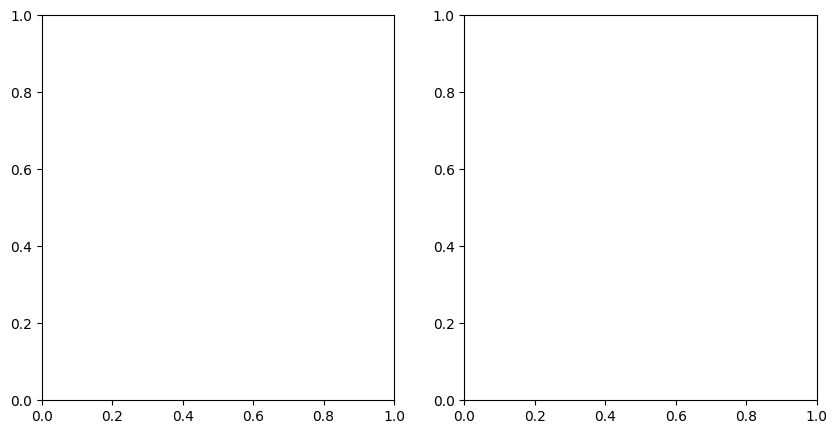

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(val_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(val_accs, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy')
ax[1].legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

model.eval()
correct_test = 0
total_test = 0
test_loss = 0.0
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Append true labels and predicted labels to the respective lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()




# Compute the test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100.0 * correct_test / total_test

# Print the test results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


# Calculate the evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))

Test Loss: 0.2516, Test Accuracy: 91.67%
Accuracy: 0.9166666666666666
Precision: 0.9302325581395349
Recall: 0.9523809523809523
F1-score: 0.9411764705882352
F1_score_macro: 0.8991596638655461
AUC-ROC: 0.8928571428571428

              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.93      0.95      0.94        42

    accuracy                           0.92        60
   macro avg       0.91      0.89      0.90        60
weighted avg       0.92      0.92      0.92        60



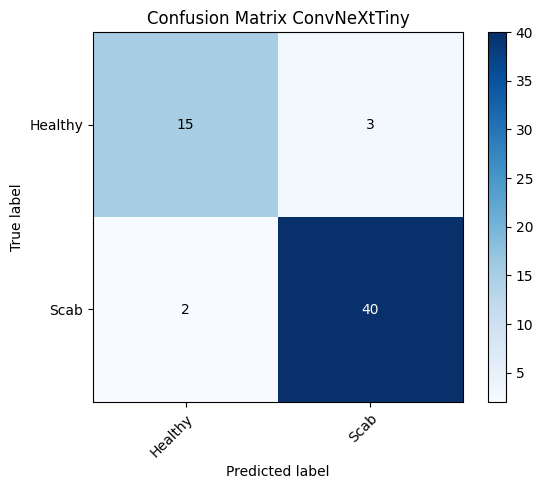

In [ ]:
# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ConvNeXtTiny")
plt.show()

# Model Swin Transformer

In [ ]:
timm.list_models('*swin*', pretrained=True) # 'swin_tiny_patch4_window7_224"'

['swin_base_patch4_window7_224.ms_in1k',
 'swin_base_patch4_window7_224.ms_in22k',
 'swin_base_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_base_patch4_window12_384.ms_in1k',
 'swin_base_patch4_window12_384.ms_in22k',
 'swin_base_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_large_patch4_window7_224.ms_in22k',
 'swin_large_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_large_patch4_window12_384.ms_in22k',
 'swin_large_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_s3_base_224.ms_in1k',
 'swin_s3_small_224.ms_in1k',
 'swin_s3_tiny_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in22k',
 'swin_small_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_tiny_patch4_window7_224.ms_in1k',
 'swin_tiny_patch4_window7_224.ms_in22k',
 'swin_tiny_patch4_window7_224.ms_in22k_ft_in1k',
 'swinv2_base_window8_256.ms_in1k',
 'swinv2_base_window12_192.ms_in22k',
 'swinv2_base_window12to16_192to256.ms_in22k_ft_in1k',
 'swinv2_base_window12to24_192to384.ms_in22k_ft_in1k',


In [ ]:
from sklearn import metrics
from sklearn.metrics import f1_score


# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define parameters
BATCHSIZE = 16
epochs = 100

# Calculate class weights
train_dataset = ImageFolder(train_path)
targets = train_dataset.targets
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)

class_weights_tensor = torch.from_numpy(class_weights)
class_weights_tensor = class_weights_tensor.to(torch.float32)

class_weights_tensor = class_weights_tensor.to(DEVICE)



def define_model(trial):
  model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, in_chans=3) 
  
  for param in model.parameters():
    param.requires_grad = False
    
  num_in_features = model.get_classifier().in_features
    
  head = []
  head.append(nn.BatchNorm1d(num_in_features))
  hidden_layers = trial.suggest_int('hidden_layers', 1, 2)
  for i in range(hidden_layers):
    first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512])
    head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
    head.append(nn.ReLU())
    drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
    head.append(nn.Dropout(p=drop_out))
    num_in_features = first_neuron
    
  head.append(nn.Linear(in_features=num_in_features, out_features=2))
  
  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():      
    param.requires_grad = True

  return model

def get_dataset():
  import torchvision.transforms as transforms
  from torchvision.datasets import ImageFolder

  transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
  
  transform_valid = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  
  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)
  
  train_data = next(iter(train_loader))
  valid_data = next(iter(valid_loader))

  return train_loader, valid_loader

def objective(trial):
  
    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Generate a loss function

    # Define your loss function with class_weights_tensor
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_dataset()

    # Initialize variables for early stopping
    best_loss = 1000000
    patience = 5
    no_improvement_count = 0

    # Train the model with early stopping
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        best_f1_score = 0.0
        total_train = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()    # Backpropagate the gradients
            optimizer.step()   # Update the model parameters

            running_loss += loss.item()

            # Compute the train accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Compute the train loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct_train / total_train

        # Evaluate the model on the validation set
        model.eval()
        correct_valid = 0
        total_valid = 0
        y_true, y_pred = [], []
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)

                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

                y_true += labels.cpu().tolist()
                y_pred += predicted.cpu().tolist()

        # Compute the validation loss and accuracy
        valid_loss /= len(valid_loader)
        valid_accuracy = 100.0 * correct_valid / total_valid


        #calculate the macro f1-score
        f1_score = metrics.f1_score(y_true, y_pred, average='macro')

        # Print the results for this epoch
        print(f"Epoch {epoch}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%, F1_score: {f1_score:.4f}")

        # Report the intermediate result
        trial.report(f1_score, epoch)

        # Check if the validation loss has improved, and if not, increase the no_improvement_count
        if valid_loss < best_loss:
            best_loss = valid_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if the f1 score has improved
        if f1_score > best_f1_score:
            best_f1_score = f1_score

        # Check if early stopping criterion is met
        if no_improvement_count >= patience:
            print("Early stopping criterion met at epoch {}".format(epoch))
            break

        # Handle pruning based on the intermediate result
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_f1_score


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-05-16 15:54:09,007] A new study created in memory with name: no-name-0ec013dd-bb47-4b85-8b0e-6f9767f4e32e


Epoch 0/100 - Train Loss: 0.6253, Train Accuracy: 68.54% - Valid Loss: 0.6561, Valid Accuracy: 47.46%, F1_score: 0.4746
Epoch 1/100 - Train Loss: 0.5611, Train Accuracy: 76.97% - Valid Loss: 0.6240, Valid Accuracy: 57.63%, F1_score: 0.5683
Epoch 2/100 - Train Loss: 0.5446, Train Accuracy: 75.84% - Valid Loss: 0.6006, Valid Accuracy: 74.58%, F1_score: 0.6845
Epoch 3/100 - Train Loss: 0.5353, Train Accuracy: 82.02% - Valid Loss: 0.5652, Valid Accuracy: 74.58%, F1_score: 0.7047
Epoch 4/100 - Train Loss: 0.4778, Train Accuracy: 83.15% - Valid Loss: 0.5529, Valid Accuracy: 72.88%, F1_score: 0.6974
Epoch 5/100 - Train Loss: 0.4491, Train Accuracy: 83.15% - Valid Loss: 0.5538, Valid Accuracy: 71.19%, F1_score: 0.6745
Epoch 6/100 - Train Loss: 0.3824, Train Accuracy: 86.52% - Valid Loss: 0.5381, Valid Accuracy: 74.58%, F1_score: 0.6719
Epoch 7/100 - Train Loss: 0.3998, Train Accuracy: 83.71% - Valid Loss: 0.4989, Valid Accuracy: 77.97%, F1_score: 0.7266
Epoch 8/100 - Train Loss: 0.4068, Train 

[I 2023-05-16 16:21:52,095] Trial 0 finished with value: 0.7942657884540876 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.0002653552931089236}. Best is trial 0 with value: 0.7942657884540876.


Epoch 26/100 - Train Loss: 0.1943, Train Accuracy: 91.57% - Valid Loss: 0.3844, Valid Accuracy: 84.75%, F1_score: 0.7943
Early stopping criterion met at epoch 26
Epoch 0/100 - Train Loss: 356.9603, Train Accuracy: 51.12% - Valid Loss: 4.2365, Valid Accuracy: 72.88%, F1_score: 0.5184
Epoch 1/100 - Train Loss: 4.6785, Train Accuracy: 57.30% - Valid Loss: 1.6313, Valid Accuracy: 71.19%, F1_score: 0.5918
Epoch 2/100 - Train Loss: 2.8039, Train Accuracy: 58.99% - Valid Loss: 1.3698, Valid Accuracy: 64.41%, F1_score: 0.5735
Epoch 3/100 - Train Loss: 2.4071, Train Accuracy: 54.49% - Valid Loss: 0.9565, Valid Accuracy: 40.68%, F1_score: 0.3892
Epoch 4/100 - Train Loss: 0.8822, Train Accuracy: 67.42% - Valid Loss: 1.5584, Valid Accuracy: 64.41%, F1_score: 0.5200
Epoch 5/100 - Train Loss: 0.8903, Train Accuracy: 66.85% - Valid Loss: 0.7601, Valid Accuracy: 57.63%, F1_score: 0.5213
Epoch 6/100 - Train Loss: 0.5963, Train Accuracy: 71.35% - Valid Loss: 1.7247, Valid Accuracy: 69.49%, F1_score: 0.4

[I 2023-05-16 16:41:18,588] Trial 1 finished with value: 0.5686021505376344 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.016936933767111507}. Best is trial 0 with value: 0.7942657884540876.


Epoch 18/100 - Train Loss: 0.8389, Train Accuracy: 65.17% - Valid Loss: 0.6320, Valid Accuracy: 71.19%, F1_score: 0.5686
Early stopping criterion met at epoch 18
Epoch 0/100 - Train Loss: 0.8528, Train Accuracy: 66.85% - Valid Loss: 0.5913, Valid Accuracy: 72.88%, F1_score: 0.7101
Epoch 1/100 - Train Loss: 0.5488, Train Accuracy: 74.72% - Valid Loss: 0.5063, Valid Accuracy: 76.27%, F1_score: 0.7283
Epoch 2/100 - Train Loss: 0.4521, Train Accuracy: 81.46% - Valid Loss: 0.5181, Valid Accuracy: 83.05%, F1_score: 0.7533
Epoch 3/100 - Train Loss: 0.4632, Train Accuracy: 83.71% - Valid Loss: 0.4461, Valid Accuracy: 79.66%, F1_score: 0.7521
Epoch 4/100 - Train Loss: 0.3940, Train Accuracy: 84.83% - Valid Loss: 0.4630, Valid Accuracy: 83.05%, F1_score: 0.7856
Epoch 5/100 - Train Loss: 0.3482, Train Accuracy: 88.20% - Valid Loss: 0.4339, Valid Accuracy: 81.36%, F1_score: 0.7594
Epoch 6/100 - Train Loss: 0.3959, Train Accuracy: 85.39% - Valid Loss: 0.7553, Valid Accuracy: 50.85%, F1_score: 0.503

[I 2023-05-16 16:58:51,933] Trial 2 finished with value: 0.8228228228228228 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.0004913068687282939}. Best is trial 2 with value: 0.8228228228228228.


Epoch 16/100 - Train Loss: 0.2703, Train Accuracy: 86.52% - Valid Loss: 0.3429, Valid Accuracy: 84.75%, F1_score: 0.8228
Early stopping criterion met at epoch 16
Epoch 0/100 - Train Loss: 0.6904, Train Accuracy: 39.33% - Valid Loss: 0.6823, Valid Accuracy: 44.07%, F1_score: 0.4348
Epoch 1/100 - Train Loss: 0.6790, Train Accuracy: 57.30% - Valid Loss: 0.6814, Valid Accuracy: 72.88%, F1_score: 0.6974
Epoch 2/100 - Train Loss: 0.6682, Train Accuracy: 77.53% - Valid Loss: 0.6780, Valid Accuracy: 71.19%, F1_score: 0.6424
Epoch 3/100 - Train Loss: 0.6661, Train Accuracy: 75.28% - Valid Loss: 0.6750, Valid Accuracy: 69.49%, F1_score: 0.6282
Epoch 4/100 - Train Loss: 0.6561, Train Accuracy: 82.02% - Valid Loss: 0.6720, Valid Accuracy: 72.88%, F1_score: 0.6570
Epoch 5/100 - Train Loss: 0.6493, Train Accuracy: 79.78% - Valid Loss: 0.6665, Valid Accuracy: 76.27%, F1_score: 0.6722
Epoch 6/100 - Train Loss: 0.6313, Train Accuracy: 78.65% - Valid Loss: 0.6614, Valid Accuracy: 76.27%, F1_score: 0.654

[I 2023-05-16 17:57:06,024] Trial 3 finished with value: 0.748547074777218 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 4.355805926893418e-05}. Best is trial 2 with value: 0.8228228228228228.


Epoch 57/100 - Train Loss: 0.1986, Train Accuracy: 92.13% - Valid Loss: 0.4788, Valid Accuracy: 81.36%, F1_score: 0.7485
Early stopping criterion met at epoch 57
Epoch 0/100 - Train Loss: 0.6874, Train Accuracy: 67.42% - Valid Loss: 0.6939, Valid Accuracy: 47.46%, F1_score: 0.3897
Epoch 1/100 - Train Loss: 0.6837, Train Accuracy: 71.91% - Valid Loss: 0.6910, Valid Accuracy: 44.07%, F1_score: 0.4073
Epoch 2/100 - Train Loss: 0.6752, Train Accuracy: 71.91% - Valid Loss: 0.6869, Valid Accuracy: 50.85%, F1_score: 0.4873
Epoch 3/100 - Train Loss: 0.6574, Train Accuracy: 74.16% - Valid Loss: 0.6851, Valid Accuracy: 57.63%, F1_score: 0.5426
Epoch 4/100 - Train Loss: 0.6482, Train Accuracy: 78.09% - Valid Loss: 0.6801, Valid Accuracy: 55.93%, F1_score: 0.5083
Epoch 5/100 - Train Loss: 0.6582, Train Accuracy: 76.97% - Valid Loss: 0.6783, Valid Accuracy: 61.02%, F1_score: 0.5472
Epoch 6/100 - Train Loss: 0.6423, Train Accuracy: 78.65% - Valid Loss: 0.6735, Valid Accuracy: 61.02%, F1_score: 0.570

[I 2023-05-16 18:19:20,994] Trial 4 finished with value: 0.6424242424242425 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 3.694753689999297e-05}. Best is trial 2 with value: 0.8228228228228228.


Epoch 21/100 - Train Loss: 0.4663, Train Accuracy: 84.83% - Valid Loss: 0.5960, Valid Accuracy: 72.88%, F1_score: 0.6424
Early stopping criterion met at epoch 21


[I 2023-05-16 18:20:30,169] Trial 5 pruned. 


Epoch 0/100 - Train Loss: 28.7239, Train Accuracy: 54.49% - Valid Loss: 3.0831, Valid Accuracy: 64.41%, F1_score: 0.3918


[I 2023-05-16 18:21:39,484] Trial 6 pruned. 


Epoch 0/100 - Train Loss: 10377.7493, Train Accuracy: 57.87% - Valid Loss: 49.8280, Valid Accuracy: 47.46%, F1_score: 0.4740
Epoch 0/100 - Train Loss: 0.6805, Train Accuracy: 62.36% - Valid Loss: 0.6853, Valid Accuracy: 59.32%, F1_score: 0.5203


[I 2023-05-16 18:23:48,748] Trial 7 pruned. 


Epoch 1/100 - Train Loss: 0.5877, Train Accuracy: 74.16% - Valid Loss: 0.6703, Valid Accuracy: 55.93%, F1_score: 0.5289


[I 2023-05-16 18:24:58,004] Trial 8 pruned. 


Epoch 0/100 - Train Loss: 0.7284, Train Accuracy: 56.74% - Valid Loss: 0.6949, Valid Accuracy: 71.19%, F1_score: 0.4668
Epoch 0/100 - Train Loss: 57.9676, Train Accuracy: 56.74% - Valid Loss: 11.0429, Valid Accuracy: 52.54%, F1_score: 0.5141


[I 2023-05-16 18:27:08,626] Trial 9 pruned. 


Epoch 1/100 - Train Loss: 20.7758, Train Accuracy: 69.10% - Valid Loss: 29.0096, Valid Accuracy: 33.90%, F1_score: 0.2865
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  5
  Number of complete trials:  5
Best trial:
  Value:  0.8228228228228228
  Params: 
    hidden_layers: 1
    first_neuron: 512
    drop_out: 0.3
    optimizer: RMSprop
    lr: 0.0004913068687282939


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.794266,2023-05-16 15:54:09.009502,2023-05-16 16:21:52.095404,0 days 00:27:43.085902,0.0,512,1,0.000265,Adam,COMPLETE
1,1,0.568602,2023-05-16 16:21:52.097067,2023-05-16 16:41:18.588219,0 days 00:19:26.491152,0.5,256,2,0.016937,RMSprop,COMPLETE
2,2,0.822823,2023-05-16 16:41:18.589672,2023-05-16 16:58:51.932928,0 days 00:17:33.343256,0.3,512,1,0.000491,RMSprop,COMPLETE
3,3,0.748547,2023-05-16 16:58:51.934635,2023-05-16 17:57:06.024371,0 days 00:58:14.089736,0.0,512,2,0.000044,AdamW,COMPLETE
4,4,0.642424,2023-05-16 17:57:06.026190,2023-05-16 18:19:20.994029,0 days 00:22:14.967839,0.0,512,2,0.000037,Adam,COMPLETE
5,5,0.391753,2023-05-16 18:19:20.995563,2023-05-16 18:20:30.169382,0 days 00:01:09.173819,0.0,256,2,0.058429,AdamW,PRUNED
6,6,0.473972,2023-05-16 18:20:30.171052,2023-05-16 18:21:39.484447,0 days 00:01:09.313395,0.5,128,2,0.053610,RMSprop,PRUNED
7,7,0.528870,2023-05-16 18:21:39.486001,2023-05-16 18:23:48.747997,0 days 00:02:09.261996,0.5,512,1,0.000079,RMSprop,PRUNED
8,8,0.466773,2023-05-16 18:23:48.749303,2023-05-16 18:24:58.004333,0 days 00:01:09.255030,0.3,512,2,0.000171,RMSprop,PRUNED
9,9,0.286512,2023-05-16 18:24:58.005973,2023-05-16 18:27:08.626479,0 days 00:02:10.620506,0.3,256,1,0.095831,AdamW,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from sklearn import metrics
from sklearn.metrics import f1_score

best_hidden_layers = study.best_params['hidden_layers']
best_neurons = study.best_params['first_neuron']
best_dropout = study.best_params['drop_out']
best_optimizer = study.best_params['optimizer']
best_lr = study.best_params['lr']
BATCHSIZE = 16
epochs = 11


# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weights
train_val_dataset = ImageFolder(train_val_path)
targets = train_val_dataset.targets
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)

class_weights_tensor = torch.from_numpy(class_weights)
class_weights_tensor = class_weights_tensor.to(torch.float32)
class_weights_tensor = class_weights_tensor.to(DEVICE)

def define_model():
  model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, in_chans=3) 
  
  for param in model.parameters():
    param.requires_grad = False
    
  num_in_features = model.get_classifier().in_features
    
  head = []
  head.append(nn.BatchNorm1d(num_in_features))
  for i in range(best_hidden_layers):
    head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
    head.append(nn.ReLU())
    head.append(nn.Dropout(p=best_dropout))
    num_in_features = best_neurons
    
  head.append(nn.Linear(in_features=num_in_features, out_features=2))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():      
    param.requires_grad = True
  
  return model

def get_dataset():
  import torchvision.transforms as transforms
  from torchvision.datasets import ImageFolder

  transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
  
  transform_valid = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  
  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=True)
  
  train_data = next(iter(train_loader))
  valid_data = next(iter(valid_loader))

  from sklearn.utils.class_weight import compute_class_weight
  targets = train_val_dataset.targets
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(targets), y = targets)
  class_weights = {i : class_weights[i] for i in range(2)}

  print(class_weights)

  return train_loader, valid_loader


# Generate the model.
model = define_model().to(DEVICE)

# Generate the optimizers.
optimizer_name = best_optimizer
lr = best_lr
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

# Generate a loss function
criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)

# Get the FashionMNIST dataset.
train_loader, valid_loader = get_dataset()

# Train the model with early stopping
for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    best_f1_score = 0.0
    total_train = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()    # Backpropagate the gradients
        optimizer.step()   # Update the model parameters

        running_loss += loss.item()

        # Compute the train accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Compute the train loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct_train / total_train

    # Evaluate the model on the validation set
    model.eval()
    correct_valid = 0
    total_valid = 0
    y_true, y_pred = [], []
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

            y_true += labels.cpu().tolist()
            y_pred += predicted.cpu().tolist()

    # Compute the validation loss and accuracy
    valid_loss /= len(valid_loader)
    valid_accuracy = 100.0 * correct_valid / total_valid


    #calculate the macro f1-score
    f1_score = metrics.f1_score(y_true, y_pred, average='macro')

    # Print the results for this epoch
    print(f"Epoch {epoch}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train_Val Accuracy: {train_accuracy:.2f}% - "
          f"Valid Loss: {valid_loss:.4f}, Test Accuracy: {valid_accuracy:.2f}%, F1_score: {f1_score:.4f}")

{0: 1.6458333333333333, 1: 0.7181818181818181}
Epoch 0/11 - Train Loss: 0.8349, Train_Val Accuracy: 60.76% - Valid Loss: 0.4646, Test Accuracy: 73.33%, F1_score: 0.7285
Epoch 1/11 - Train Loss: 0.4600, Train_Val Accuracy: 80.59% - Valid Loss: 0.3620, Test Accuracy: 83.33%, F1_score: 0.8206
Epoch 2/11 - Train Loss: 0.4295, Train_Val Accuracy: 81.86% - Valid Loss: 0.2921, Test Accuracy: 88.33%, F1_score: 0.8703
Epoch 3/11 - Train Loss: 0.3878, Train_Val Accuracy: 81.43% - Valid Loss: 0.3366, Test Accuracy: 80.00%, F1_score: 0.7917
Epoch 4/11 - Train Loss: 0.3087, Train_Val Accuracy: 87.34% - Valid Loss: 0.2153, Test Accuracy: 90.00%, F1_score: 0.8875
Epoch 5/11 - Train Loss: 0.3236, Train_Val Accuracy: 87.34% - Valid Loss: 0.1961, Test Accuracy: 96.67%, F1_score: 0.9603
Epoch 6/11 - Train Loss: 0.4119, Train_Val Accuracy: 78.90% - Valid Loss: 0.1958, Test Accuracy: 96.67%, F1_score: 0.9603
Epoch 7/11 - Train Loss: 0.2914, Train_Val Accuracy: 87.76% - Valid Loss: 0.1585, Test Accuracy: 96

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

model.eval()
correct_test = 0
total_test = 0
test_loss = 0.0
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Append true labels and predicted labels to the respective lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()




# Compute the test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100.0 * correct_test / total_test

# Print the test results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


# Calculate the evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))

Test Loss: 0.1748, Test Accuracy: 95.00%
Accuracy: 0.95
Precision: 0.975609756097561
Recall: 0.9523809523809523
F1-score: 0.963855421686747
F1_score_macro: 0.9413871703028329
AUC-ROC: 0.9484126984126984

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        18
           1       0.98      0.95      0.96        42

    accuracy                           0.95        60
   macro avg       0.94      0.95      0.94        60
weighted avg       0.95      0.95      0.95        60



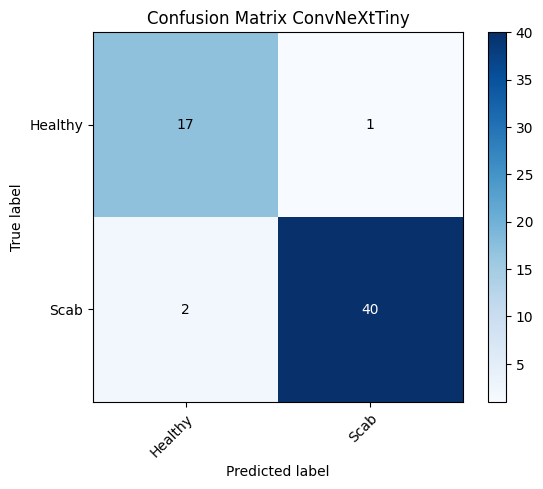

In [ ]:
# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ConvNeXtTiny")
plt.show()